In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from joblib import dump

def get_train_data():
    data = pd.read_csv("data/train_final.csv");
    mat = data.values
    X = mat[:, 2:]
    y = mat[:, 1:2]
    return (X,np.ravel(y))

import numpy as np
import matplotlib.pyplot as plt
import gzip

image_size = 28
num_pixels = image_size**2

nrows = 3
ncols = 5
tot = nrows * ncols

N = 10

def load_data(s, num_images):
    f = gzip.open('/content/drive/My Drive/data/' + s + '_set/' + s + '-images-idx3-ubyte.gz','r')

    f.read(16)
    im_buf = f.read(image_size * image_size * num_images)
    data = np.frombuffer(im_buf, dtype=np.uint8).astype(np.float32)
    data = data.reshape(num_images, num_pixels)
    """
    image = np.asarray(data[0]).squeeze()
    plt.imshow(image)
    plt.show()
    """
    f = gzip.open('/content/drive/My Drive/data/' + s + '_set/' + s + '-labels-idx1-ubyte.gz','r')
    f.read(8)
    la_buf = f.read(1 * num_images)
    labels = np.frombuffer(la_buf, dtype=np.uint8).astype(np.int64)
#    onehot = np.zeros((num_images, N))
#    for i, l in enumerate(labels):
#        onehot[i, l] = 1
    return data, labels

def normalize_data(data, mean, std):
    for i, s in enumerate(std):
        std[i] = max(s, 0.1)
    for i, x_i in enumerate(data):
        data[i] = (x_i - mean) / std
    return data

train_images, train_labels = load_data('train', 60000)
test_images, test_labels = load_data('t10k', 10000)


mean = np.mean(train_images, axis=0)
std = np.std(train_images, axis=0)
train_images = normalize_data(train_images, mean, std)
test_images = normalize_data(test_images, mean, std)

In [0]:
import torch

device = torch.device('cuda')

torch_test_images = torch.from_numpy(test_images).float().to(device)
torch_test_labels = torch.from_numpy(test_labels).to(device)

torch_train_images = torch.from_numpy(train_images).float().to(device)
torch_train_labels = torch.from_numpy(train_labels).to(device)

def test_accuracy(model):
    with torch.no_grad():
        y_pred = model.forward(torch_test_images)
        _, predicted = torch.max(y_pred.data, 1)
        total = torch_test_labels.size(0)
        correct = (predicted == torch_test_labels).sum().item()

        return correct / total

def train_accuracy(model):
    with torch.no_grad():
        y_pred = model.forward(torch_train_images)
        _, predicted = torch.max(y_pred.data, 1)
        total = torch_train_labels.size(0)
        correct = (predicted == torch_train_labels).sum().item()

        return correct / total

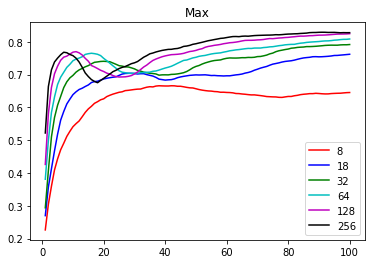

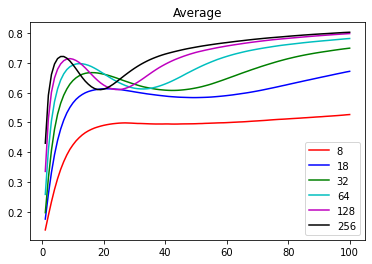

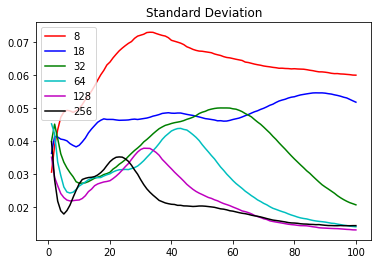

In [0]:


D_in = num_pixels
H_vals = [8, 18, 32, 64, 128, 256]
D_out = 10

colors = ['r', 'b', 'g', 'c', 'm', 'k']

NUM_ITER = 100
BATCH_SIZE = 128
ETA = 0.001
REPS = 100

idx = np.arange(1, NUM_ITER + 1)
max_accuracies = np.zeros((len(H_vals), idx.shape[0]))
averages = np.zeros((len(H_vals), idx.shape[0]))
std = np.zeros((len(H_vals), idx.shape[0], REPS))

for seed in range(REPS):
#    print('Rep: {}'.format(seed + 1))
    for i, H in enumerate(H_vals):
        np.random.seed(seed=seed)
        torch.random.manual_seed(seed)

        model = torch.nn.Sequential(
            torch.nn.Linear(D_in, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, D_out),
            torch.nn.Softmax(dim=0)
        ).to(device)

        loss_fn = torch.nn.CrossEntropyLoss()

        optimizer = torch.optim.Adam(model.parameters(), lr=ETA)

        for j in range(NUM_ITER):
            indices = np.random.choice(60000, size=BATCH_SIZE, replace=False)
            batch_images = train_images[indices]
            batch_labels = train_labels[indices]

            torch_images = torch.from_numpy(batch_images).float().to(device)
            torch_labels = torch.from_numpy(batch_labels).to(device)

            y_pred = model.forward(torch_images)
            loss = loss_fn(y_pred, torch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            test_acc = test_accuracy(model)
            max_accuracies[i, j] = max(max_accuracies[i, j], test_acc)
            averages[i, j] += test_acc
            std[i, j, seed] = test_acc

    plt.figure(0)
    plt.clf()
    for i, vec in enumerate(max_accuracies):
        plt.plot(idx, vec, label=str(H_vals[i]), c=colors[i])
    plt.legend()
    plt.title('Max')

    plt.figure(1)
    plt.clf()
    for i, vec in enumerate(averages):
        plt.plot(idx, vec / (seed + 1), label=str(H_vals[i]), c=colors[i])
    plt.legend()
    plt.title('Average')

    plt.figure(2)
    plt.clf()
    for i, vec in enumerate(averages):
        plt.plot(idx, np.std(std[i], axis=1), label=str(H_vals[i]), c=colors[i])
    plt.legend()
    plt.title('Standard Deviation')

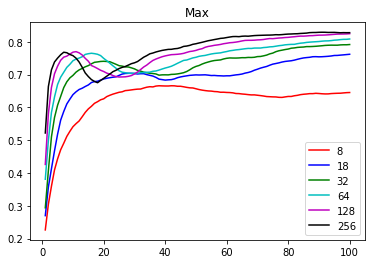

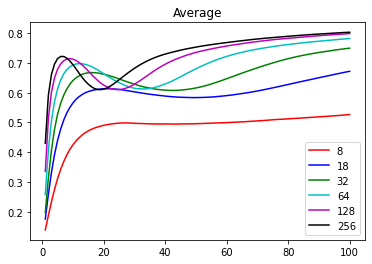

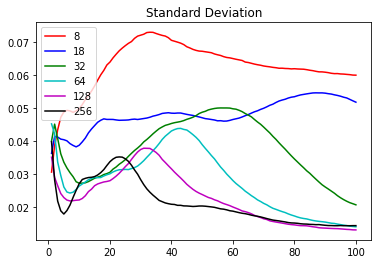

In [6]:
#training accuracy

D_in = num_pixels
H_vals = [8, 18, 32, 64, 128, 256]
D_out = 10

colors = ['r', 'b', 'g', 'c', 'm', 'k']

NUM_ITER = 100
BATCH_SIZE = 128
ETA = 0.001
REPS = 100

idx = np.arange(1, NUM_ITER + 1)
max_accuracies = np.zeros((len(H_vals), idx.shape[0]))
averages = np.zeros((len(H_vals), idx.shape[0]))
std = np.zeros((len(H_vals), idx.shape[0], REPS))

for seed in range(REPS):
#    print('Rep: {}'.format(seed + 1))
    for i, H in enumerate(H_vals):
        np.random.seed(seed=seed)
        torch.random.manual_seed(seed)

        model = torch.nn.Sequential(
            torch.nn.Linear(D_in, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, D_out),
            torch.nn.Softmax(dim=0)
        ).to(device)

        loss_fn = torch.nn.CrossEntropyLoss()

        optimizer = torch.optim.Adam(model.parameters(), lr=ETA)

        for j in range(NUM_ITER):
            indices = np.random.choice(60000, size=BATCH_SIZE, replace=False)
            batch_images = train_images[indices]
            batch_labels = train_labels[indices]

            torch_images = torch.from_numpy(batch_images).float().to(device)
            torch_labels = torch.from_numpy(batch_labels).to(device)

            y_pred = model.forward(torch_images)
            loss = loss_fn(y_pred, torch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_acc = train_accuracy(model)
            max_accuracies[i, j] = max(max_accuracies[i, j], train_acc)
            averages[i, j] += train_acc
            std[i, j, seed] = train_acc

    plt.figure(0)
    plt.clf()
    for i, vec in enumerate(max_accuracies):
        plt.plot(idx, vec, label=str(H_vals[i]), c=colors[i])
    plt.legend()
    plt.title('Max')

    plt.figure(1)
    plt.clf()
    for i, vec in enumerate(averages):
        plt.plot(idx, vec / (seed + 1), label=str(H_vals[i]), c=colors[i])
    plt.legend()
    plt.title('Average')

    plt.figure(2)
    plt.clf()
    for i, vec in enumerate(averages):
        plt.plot(idx, np.std(std[i], axis=1), label=str(H_vals[i]), c=colors[i])
    plt.legend()
    plt.title('Standard Deviation')

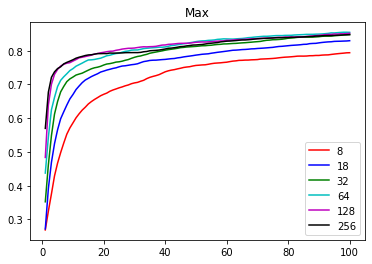

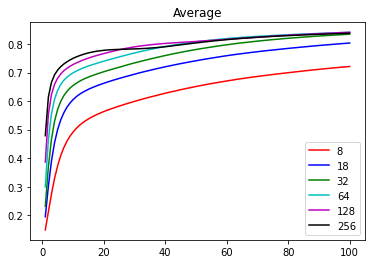

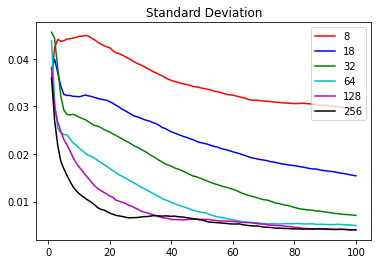

In [0]:
# SAME THING AS ABOVE BUT WITH SIGMOID INSTEAD OF ReLU
device = torch.device('cuda')

D_in = num_pixels
H_vals = [8, 18, 32, 64, 128, 256]
D_out = 10

colors = ['r', 'b', 'g', 'c', 'm', 'k']

NUM_ITER = 100
BATCH_SIZE = 128
ETA = 0.001
REPS = 100

idx = np.arange(1, NUM_ITER + 1)
max_accuracies = np.zeros((len(H_vals), idx.shape[0]))
averages = np.zeros((len(H_vals), idx.shape[0]))
std = np.zeros((len(H_vals), idx.shape[0], REPS))

for seed in range(REPS):
#    print('Rep: {}'.format(seed + 1))
    for i, H in enumerate(H_vals):
        np.random.seed(seed=seed)
        torch.random.manual_seed(seed)

        model = torch.nn.Sequential(
            torch.nn.Linear(D_in, H),
            torch.nn.Sigmoid(),
            torch.nn.Linear(H, D_out),
            torch.nn.Softmax(dim=0)
        ).to(device)

        loss_fn = torch.nn.CrossEntropyLoss()

        optimizer = torch.optim.Adam(model.parameters(), lr=ETA)

        for j in range(NUM_ITER):
            indices = np.random.choice(60000, size=BATCH_SIZE, replace=False)
            batch_images = train_images[indices]
            batch_labels = train_labels[indices]

            torch_images = torch.from_numpy(batch_images).float().to(device)
            torch_labels = torch.from_numpy(batch_labels).to(device)

            y_pred = model.forward(torch_images)
            loss = loss_fn(y_pred, torch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            test_acc = test_accuracy(model)
            max_accuracies[i, j] = max(max_accuracies[i, j], test_acc)
            averages[i, j] += test_acc
            std[i, j, seed] = test_acc

    plt.figure(0)
    plt.clf()
    for i, vec in enumerate(max_accuracies):
        plt.plot(idx, vec, label=str(H_vals[i]), c=colors[i])
    plt.legend()
    plt.title('Max')

    plt.figure(1)
    plt.clf()
    for i, vec in enumerate(averages):
        plt.plot(idx, vec / (seed + 1), label=str(H_vals[i]), c=colors[i])
    plt.legend()
    plt.title('Average')

    plt.figure(2)
    plt.clf()
    for i, vec in enumerate(averages):
        plt.plot(idx, np.std(std[i], axis=1), label=str(H_vals[i]), c=colors[i])
    plt.legend()
    plt.title('Standard Deviation')

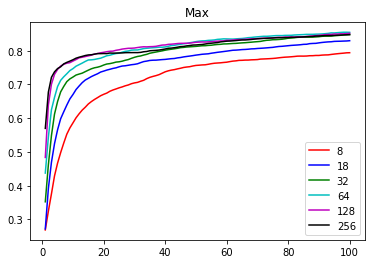

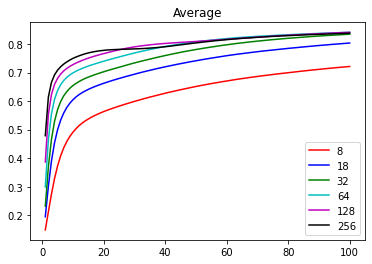

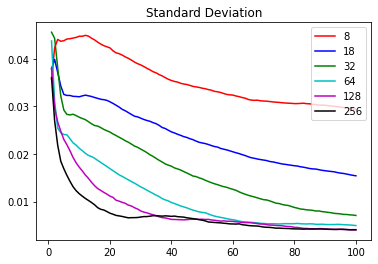

In [7]:
# SAME THING AS ABOVE BUT WITH SIGMOID INSTEAD OF ReLU
device = torch.device('cuda')

D_in = num_pixels
H_vals = [8, 18, 32, 64, 128, 256]
D_out = 10

colors = ['r', 'b', 'g', 'c', 'm', 'k']

NUM_ITER = 100
BATCH_SIZE = 128
ETA = 0.001
REPS = 100

idx = np.arange(1, NUM_ITER + 1)
max_accuracies = np.zeros((len(H_vals), idx.shape[0]))
averages = np.zeros((len(H_vals), idx.shape[0]))
std = np.zeros((len(H_vals), idx.shape[0], REPS))

for seed in range(REPS):
#    print('Rep: {}'.format(seed + 1))
    for i, H in enumerate(H_vals):
        np.random.seed(seed=seed)
        torch.random.manual_seed(seed)

        model = torch.nn.Sequential(
            torch.nn.Linear(D_in, H),
            torch.nn.Sigmoid(),
            torch.nn.Linear(H, D_out),
            torch.nn.Softmax(dim=0)
        ).to(device)

        loss_fn = torch.nn.CrossEntropyLoss()

        optimizer = torch.optim.Adam(model.parameters(), lr=ETA)

        for j in range(NUM_ITER):
            indices = np.random.choice(60000, size=BATCH_SIZE, replace=False)
            batch_images = train_images[indices]
            batch_labels = train_labels[indices]

            torch_images = torch.from_numpy(batch_images).float().to(device)
            torch_labels = torch.from_numpy(batch_labels).to(device)

            y_pred = model.forward(torch_images)
            loss = loss_fn(y_pred, torch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_acc = train_accuracy(model)
            max_accuracies[i, j] = max(max_accuracies[i, j], train_acc)
            averages[i, j] += train_acc
            std[i, j, seed] = train_acc

    plt.figure(0)
    plt.clf()
    for i, vec in enumerate(max_accuracies):
        plt.plot(idx, vec, label=str(H_vals[i]), c=colors[i])
    plt.legend()
    plt.title('Max')

    plt.figure(1)
    plt.clf()
    for i, vec in enumerate(averages):
        plt.plot(idx, vec / (seed + 1), label=str(H_vals[i]), c=colors[i])
    plt.legend()
    plt.title('Average')

    plt.figure(2)
    plt.clf()
    for i, vec in enumerate(averages):
        plt.plot(idx, np.std(std[i], axis=1), label=str(H_vals[i]), c=colors[i])
    plt.legend()
    plt.title('Standard Deviation')

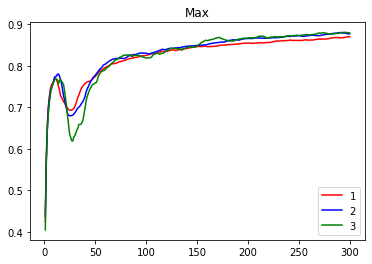

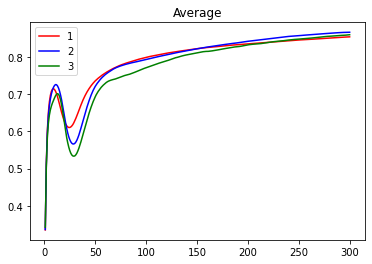

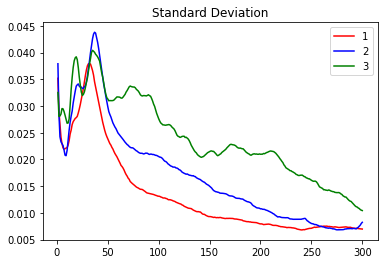

In [8]:
# Using ReLU Activation, multiple layers
device = torch.device('cuda')

D_in = num_pixels
H = 128
D_out = 10

num_layers = [1, 2, 3]

colors = ['r', 'b', 'g']

NUM_ITER = 300
BATCH_SIZE = 128
ETA = 0.001
REPS = 100

idx = np.arange(1, NUM_ITER + 1)
max_accuracies = np.zeros((len(num_layers), idx.shape[0]))
averages = np.zeros((len(num_layers), idx.shape[0]))
std = np.zeros((len(num_layers), idx.shape[0], REPS))

for seed in range(REPS):
#    print('Rep: {}'.format(seed + 1))
    for i, n in enumerate(num_layers):
        np.random.seed(seed=seed)
        torch.random.manual_seed(seed)

        layers = [torch.nn.Linear(D_in, H), torch.nn.ReLU()]
        for j in range(n - 1):
            layers.append(torch.nn.Linear(H, H))
            layers.append(torch.nn.ReLU())

        model = torch.nn.Sequential(
            *layers,
            torch.nn.Linear(H, D_out),
            torch.nn.Softmax(dim=0)
        ).to(device)

        loss_fn = torch.nn.CrossEntropyLoss()

        optimizer = torch.optim.Adam(model.parameters(), lr=ETA)

        for j in range(NUM_ITER):
            indices = np.random.choice(60000, size=BATCH_SIZE, replace=False)
            batch_images = train_images[indices]
            batch_labels = train_labels[indices]

            torch_images = torch.from_numpy(batch_images).float().to(device)
            torch_labels = torch.from_numpy(batch_labels).to(device)

            y_pred = model.forward(torch_images)
            loss = loss_fn(y_pred, torch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            test_acc = test_accuracy(model)
            max_accuracies[i, j] = max(max_accuracies[i, j], test_acc)
            averages[i, j] += test_acc
            std[i, j, seed] = test_acc

    plt.figure(0)
    plt.clf()
    for i, vec in enumerate(max_accuracies):
        plt.plot(idx, vec, label=str(num_layers[i]), c=colors[i])
    plt.legend()
    plt.title('Max')

    plt.figure(1)
    plt.clf()
    for i, vec in enumerate(averages):
        plt.plot(idx, vec / (seed + 1), label=str(num_layers[i]), c=colors[i])
    plt.legend()
    plt.title('Average')

    plt.figure(2)
    plt.clf()
    for i, vec in enumerate(averages):
        plt.plot(idx, np.std(std[i], axis=1), label=str(num_layers[i]), c=colors[i])
    plt.legend()
    plt.title('Standard Deviation')

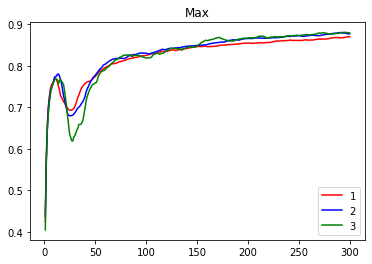

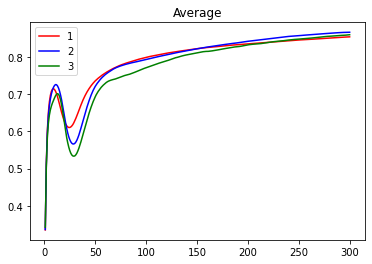

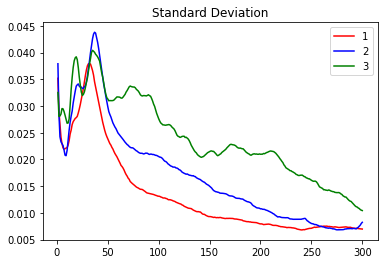

In [9]:
device = torch.device('cuda')

D_in = num_pixels
H = 128
D_out = 10

num_layers = [1, 2, 3]

colors = ['r', 'b', 'g']

NUM_ITER = 300
BATCH_SIZE = 128
ETA = 0.001
REPS = 100

idx = np.arange(1, NUM_ITER + 1)
max_accuracies = np.zeros((len(num_layers), idx.shape[0]))
averages = np.zeros((len(num_layers), idx.shape[0]))
std = np.zeros((len(num_layers), idx.shape[0], REPS))

for seed in range(REPS):
#    print('Rep: {}'.format(seed + 1))
    for i, n in enumerate(num_layers):
        np.random.seed(seed=seed)
        torch.random.manual_seed(seed)

        layers = [torch.nn.Linear(D_in, H), torch.nn.ReLU()]
        for j in range(n - 1):
            layers.append(torch.nn.Linear(H, H))
            layers.append(torch.nn.ReLU())

        model = torch.nn.Sequential(
            *layers,
            torch.nn.Linear(H, D_out),
            torch.nn.Softmax(dim=0)
        ).to(device)

        loss_fn = torch.nn.CrossEntropyLoss()

        optimizer = torch.optim.Adam(model.parameters(), lr=ETA)

        for j in range(NUM_ITER):
            indices = np.random.choice(60000, size=BATCH_SIZE, replace=False)
            batch_images = train_images[indices]
            batch_labels = train_labels[indices]

            torch_images = torch.from_numpy(batch_images).float().to(device)
            torch_labels = torch.from_numpy(batch_labels).to(device)

            y_pred = model.forward(torch_images)
            loss = loss_fn(y_pred, torch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_acc = train_accuracy(model)
            max_accuracies[i, j] = max(max_accuracies[i, j], train_acc)
            averages[i, j] += train_acc
            std[i, j, seed] = train_acc

    plt.figure(0)
    plt.clf()
    for i, vec in enumerate(max_accuracies):
        plt.plot(idx, vec, label=str(num_layers[i]), c=colors[i])
    plt.legend()
    plt.title('Max')

    plt.figure(1)
    plt.clf()
    for i, vec in enumerate(averages):
        plt.plot(idx, vec / (seed + 1), label=str(num_layers[i]), c=colors[i])
    plt.legend()
    plt.title('Average')

    plt.figure(2)
    plt.clf()
    for i, vec in enumerate(averages):
        plt.plot(idx, np.std(std[i], axis=1), label=str(num_layers[i]), c=colors[i])
    plt.legend()
    plt.title('Standard Deviation')

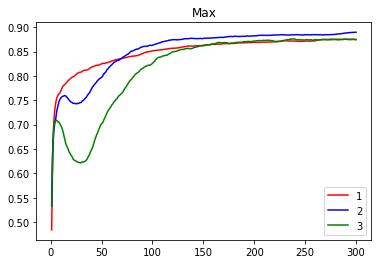

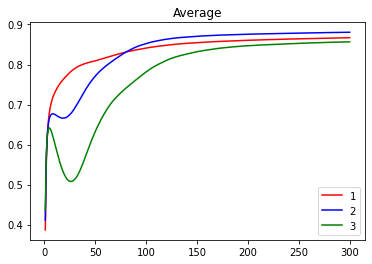

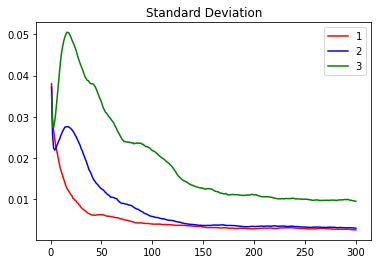

In [10]:
# Using Sigmoid Activation, multiple layers
device = torch.device('cuda')

D_in = num_pixels
H = 128
D_out = 10

num_layers = [1, 2, 3]

colors = ['r', 'b', 'g']

NUM_ITER = 300
BATCH_SIZE = 128
ETA = 0.001
REPS = 100

idx = np.arange(1, NUM_ITER + 1)
max_accuracies = np.zeros((len(num_layers), idx.shape[0]))
averages = np.zeros((len(num_layers), idx.shape[0]))
std = np.zeros((len(num_layers), idx.shape[0], REPS))

for seed in range(REPS):
#    print('Rep: {}'.format(seed + 1))
    for i, n in enumerate(num_layers):
        np.random.seed(seed=seed)
        torch.random.manual_seed(seed)

        layers = [torch.nn.Linear(D_in, H), torch.nn.Sigmoid()]
        for j in range(n - 1):
            layers.append(torch.nn.Linear(H, H))
            layers.append(torch.nn.Sigmoid())

        model = torch.nn.Sequential(
            *layers,
            torch.nn.Linear(H, D_out),
            torch.nn.Softmax(dim=0)
        ).to(device)

        loss_fn = torch.nn.CrossEntropyLoss()

        optimizer = torch.optim.Adam(model.parameters(), lr=ETA)

        for j in range(NUM_ITER):
            indices = np.random.choice(60000, size=BATCH_SIZE, replace=False)
            batch_images = train_images[indices]
            batch_labels = train_labels[indices]

            torch_images = torch.from_numpy(batch_images).float().to(device)
            torch_labels = torch.from_numpy(batch_labels).to(device)

            y_pred = model.forward(torch_images)
            loss = loss_fn(y_pred, torch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            test_acc = test_accuracy(model)
            max_accuracies[i, j] = max(max_accuracies[i, j], test_acc)
            averages[i, j] += test_acc
            std[i, j, seed] = test_acc

    plt.figure(0)
    plt.clf()
    for i, vec in enumerate(max_accuracies):
        plt.plot(idx, vec, label=str(num_layers[i]), c=colors[i])
    plt.legend()
    plt.title('Max')

    plt.figure(1)
    plt.clf()
    for i, vec in enumerate(averages):
        plt.plot(idx, vec / (seed + 1), label=str(num_layers[i]), c=colors[i])
    plt.legend()
    plt.title('Average')

    plt.figure(2)
    plt.clf()
    for i, vec in enumerate(averages):
        plt.plot(idx, np.std(std[i], axis=1), label=str(num_layers[i]), c=colors[i])
    plt.legend()
    plt.title('Standard Deviation')

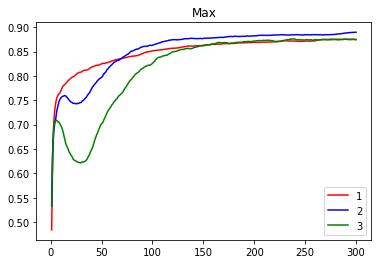

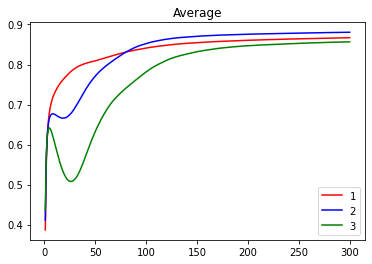

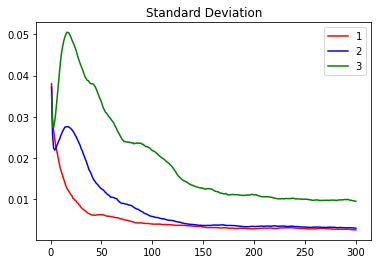

In [11]:
device = torch.device('cuda')

D_in = num_pixels
H = 128
D_out = 10

num_layers = [1, 2, 3]

colors = ['r', 'b', 'g']

NUM_ITER = 300
BATCH_SIZE = 128
ETA = 0.001
REPS = 100

idx = np.arange(1, NUM_ITER + 1)
max_accuracies = np.zeros((len(num_layers), idx.shape[0]))
averages = np.zeros((len(num_layers), idx.shape[0]))
std = np.zeros((len(num_layers), idx.shape[0], REPS))

for seed in range(REPS):
#    print('Rep: {}'.format(seed + 1))
    for i, n in enumerate(num_layers):
        np.random.seed(seed=seed)
        torch.random.manual_seed(seed)

        layers = [torch.nn.Linear(D_in, H), torch.nn.Sigmoid()]
        for j in range(n - 1):
            layers.append(torch.nn.Linear(H, H))
            layers.append(torch.nn.Sigmoid())

        model = torch.nn.Sequential(
            *layers,
            torch.nn.Linear(H, D_out),
            torch.nn.Softmax(dim=0)
        ).to(device)

        loss_fn = torch.nn.CrossEntropyLoss()

        optimizer = torch.optim.Adam(model.parameters(), lr=ETA)

        for j in range(NUM_ITER):
            indices = np.random.choice(60000, size=BATCH_SIZE, replace=False)
            batch_images = train_images[indices]
            batch_labels = train_labels[indices]

            torch_images = torch.from_numpy(batch_images).float().to(device)
            torch_labels = torch.from_numpy(batch_labels).to(device)

            y_pred = model.forward(torch_images)
            loss = loss_fn(y_pred, torch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_acc = train_accuracy(model)
            max_accuracies[i, j] = max(max_accuracies[i, j], train_acc)
            averages[i, j] += train_acc
            std[i, j, seed] = train_acc

    plt.figure(0)
    plt.clf()
    for i, vec in enumerate(max_accuracies):
        plt.plot(idx, vec, label=str(num_layers[i]), c=colors[i])
    plt.legend()
    plt.title('Max')

    plt.figure(1)
    plt.clf()
    for i, vec in enumerate(averages):
        plt.plot(idx, vec / (seed + 1), label=str(num_layers[i]), c=colors[i])
    plt.legend()
    plt.title('Average')

    plt.figure(2)
    plt.clf()
    for i, vec in enumerate(averages):
        plt.plot(idx, np.std(std[i], axis=1), label=str(num_layers[i]), c=colors[i])
    plt.legend()
    plt.title('Standard Deviation')